In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils import *
from Evaluation import *
from Classes import ABQuadrupel
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd

# Hefekulturen

## Define Files to Evaluate

Please edit the path to the reference plate (`path_to_reference_plate`) and experiment plate (`path_to_experiment_plate`) as well as the folder to save the results to (`save_results_folder`)

**Attention** Please make sure that the images are cropped, in such way that only the yeast colonies are visible.

In [3]:
# path_to_reference_plate = r"./Data\36_MPA_Cu0_d3.JPG"
path_to_reference_plate = r"./Data/36_MPA_ref_d3.JPG"
path_to_experiment_plate = r"./Data\36_MPA_Cu0_d3.JPG"

save_results_folder = r"./Results/"

In [4]:
# IMG_SIZE = 8
MIN_COLONY_SIZE = 250
P_VALUE_NULLHYPOTHESIS = 0.01

In [5]:
os.makedirs(save_results_folder, exist_ok=True)

## Open and Preprocess Images

### Open Images as Binary

c:\Users\Hannah\anaconda3\envs\hefekulturen\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Hannah\anaconda3\envs\hefekulturen\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


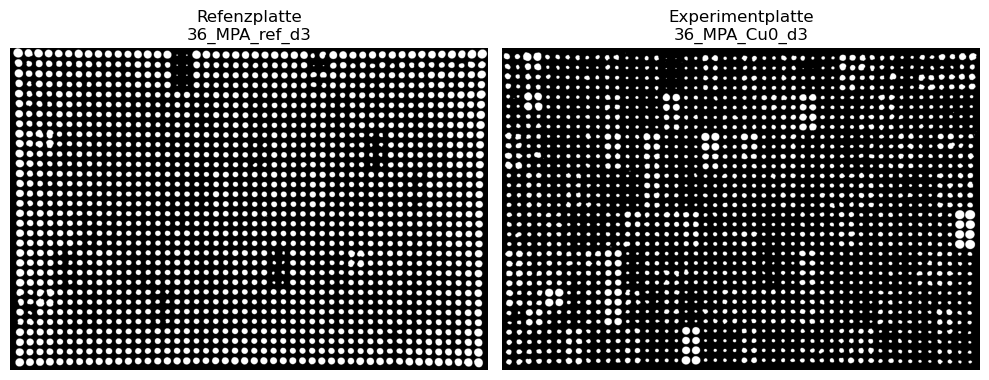

In [6]:
reference_plate = open_image(path_to_reference_plate)
experiment_plate = open_image(path_to_experiment_plate)

fig, axs = plt.subplots(1,2, figsize = (10,10*2))
axs[0].imshow(reference_plate, cmap="gray")
axs[1].imshow(experiment_plate, cmap="gray")
axs[0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
axs[1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()
plt.show()

### Compute Colony Sizes

Hint: if grid is not working properly, try to increase/decrease `erosion_iterations_ref` or `erosion_iterations_exp` by $\pm 1$

In [7]:
erosion_iterations_ref = 4
erosion_iterations_exp = 4


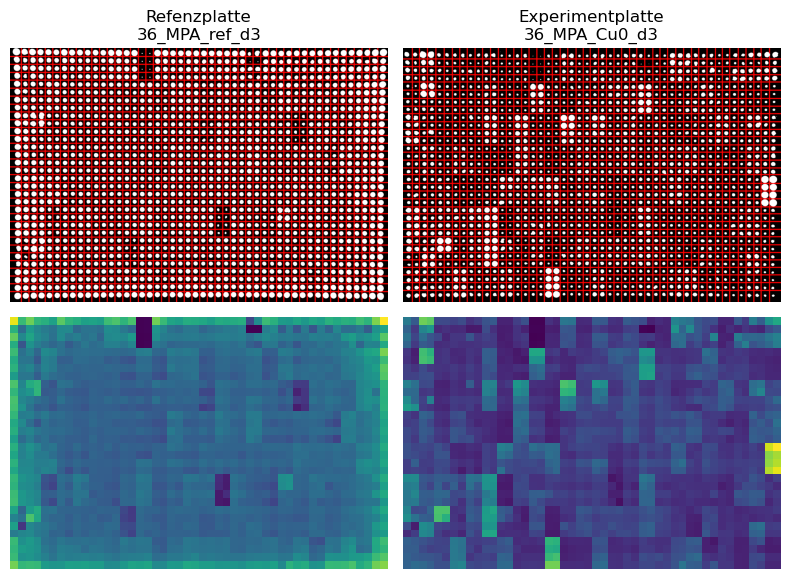

In [8]:
rgb_grid_reference, xmins_idx_reference, ymins_idx_reference = compute_grid(reference_plate, erosion_iterations = erosion_iterations_ref)
rgb_grid_experiment, xmins_idx_experiment, ymins_idx_experiment = compute_grid(experiment_plate, erosion_iterations = erosion_iterations_exp)

sizes_reference,_,_,_,_ = compute_sizes(reference_plate, xmins_idx_reference, ymins_idx_reference)
sizes_experiment, x_start, x_end, y_start, y_end = compute_sizes(experiment_plate, xmins_idx_experiment, ymins_idx_experiment)

if(sizes_reference.shape != sizes_experiment.shape):
    print("ERROR::Please check grid computation. The sizes of the grids don't match between experiment plate "+str(sizes_experiment.shape)+" and reference plate "+str(sizes_reference.shape))
else: 
    fig, axs = plt.subplots(2,2, figsize = (4*2,4*1.5))
    axs[0,0].imshow(rgb_grid_reference)
    axs[0,1].imshow(rgb_grid_experiment)
    axs[0,0].set_title("Refenzplatte\n"+Path(path_to_reference_plate).stem)
    axs[0,1].set_title("Experimentplatte\n"+Path(path_to_experiment_plate).stem)
    axs[0,0].set_axis_off()
    axs[0,1].set_axis_off()

    axs[1,0].imshow(sizes_reference) #, cmap= "plasma")
    axs[1,1].imshow(sizes_experiment) #, cmap= "plasma")
    axs[1,0].set_axis_off()
    axs[1,1].set_axis_off()
    plt.tight_layout()
    plt.autoscale(False)
    plt.show()



## Evaluate
- Normalize experimental plate in relation to reference plate
- Find invalid quadruples
- Find siginificant differences between row A and row B
- Find quadruple where either all colonies of the row A quadruple or all colonies of the row B quadruple is larger than median of reference plate
- Saves .pdf into results folder with images

**Open questions: Currently sizes > median of reference plate but probably mean growth of quadruple > than mean growth of corresponting quadruple on the reference plate?**
Therefore adapt `PERCENTILE` to a value in tange 0-100 and test for the best fitting one.

In [9]:
PERCENTILE = 50

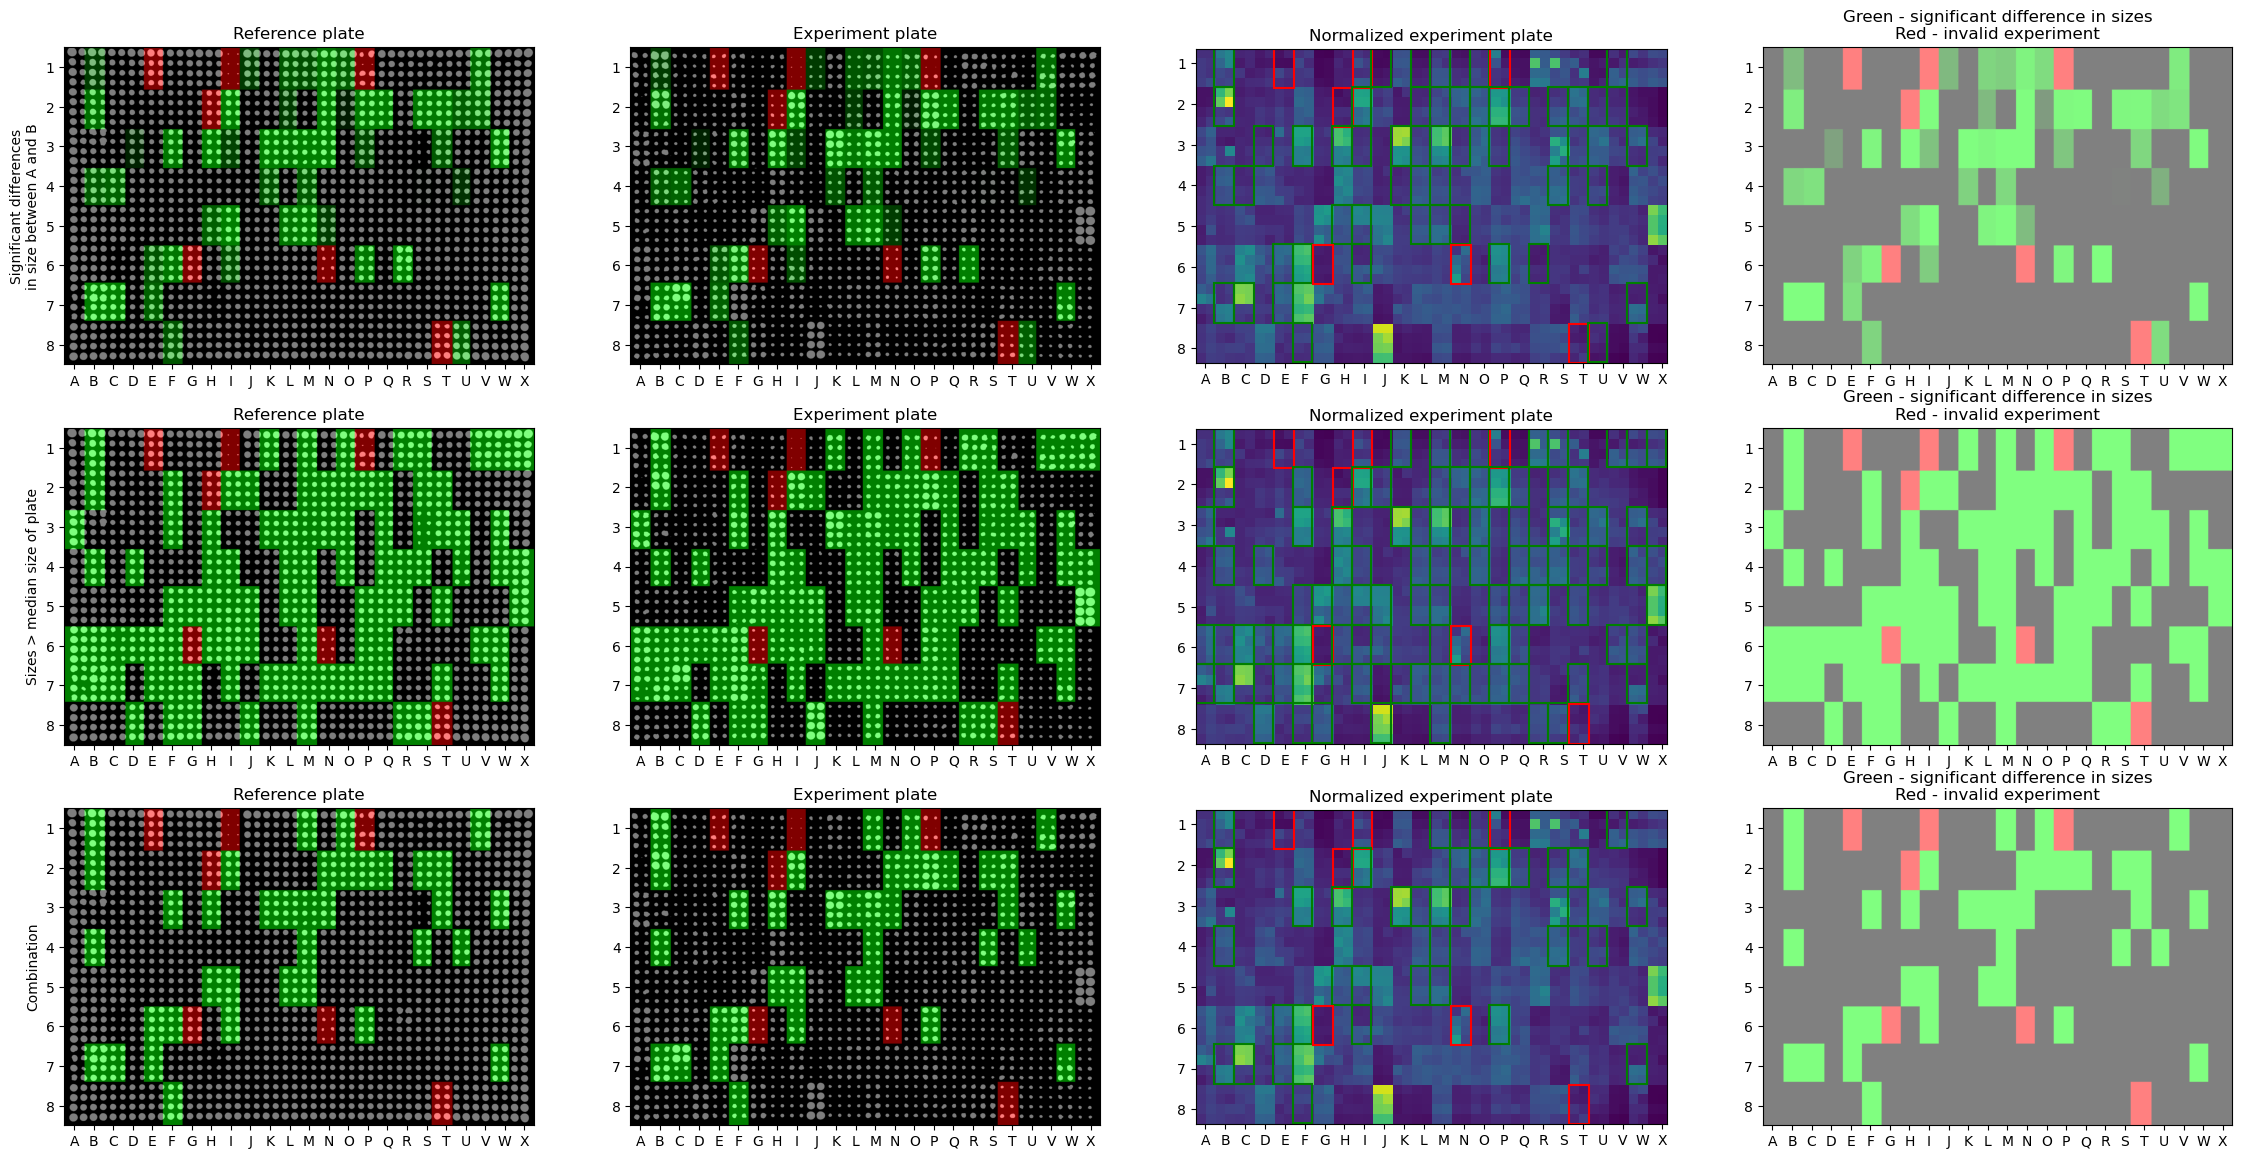

In [10]:
quadruples = evaluate(experiment_plate, reference_plate, sizes_experiment, sizes_reference, x_start, x_end, y_start, y_end, MIN_COLONY_SIZE, P_VALUE_NULLHYPOTHESIS, PERCENTILE, log_dir = save_results_folder+"Result_"+str(Path(path_to_experiment_plate).stem)+".pdf")

## Save Data to Excel Sheet

In [11]:
data = {'position': [quad.position[1]+" "+quad.position[0] for quad in quadruples], 
        'name': [str(quad.name) for quad in quadruples], 
        'p-value': [quad.p_value for quad in quadruples], 
        'max mean size': [quad.max_mean_growth for quad in quadruples],
        'bigger row': [quad.bigger_row for quad in quadruples],
        'bigger than percentile': [quad.bigger_than_median for quad in quadruples],
        'is valid' : [quad.is_valid for quad in quadruples], 
        'sizes A': [str(quad.quadrupelA.sizes) for quad in quadruples], 
        'sizes B': [str(quad.quadrupelB.sizes) for quad in quadruples],
        'ordinal scale': [quad.ordinal_scale for quad in quadruples]}
df = pd.DataFrame(data=data)    

df = df.sort_values(by=['ordinal scale'], ascending=False)
df.to_excel(save_results_folder+"/Result_"+str(Path(path_to_experiment_plate).stem)+".xlsx")
df

,position,name,p-value,max mean size,bigger row,bigger than percentile,is valid,sizes A,sizes B,ordinal scale
0,C 7,,6.091434e-08,1.920563,A,True,True,[1.91666667 1.8933121 1.97390572 1.89836661],[0.54907975 0.5508831 0.49883268 0.43582641],381
1,K 3,,5.859062e-06,2.014015,A,True,True,[2.03507271 2.0502693 2.04708098 1.92363636],[1.27288579 1.26635945 1.28808594 1.20845624],380
2,M 3,,3.884849e-05,1.739227,A,True,True,[1.6717412 1.79272326 1.68181818 1.8106267 ],[1.2300885 1.26636569 1.1109375 1.1418637 ],374
3,H 3,,1.075208e-04,1.644321,A,True,True,[1.70155039 1.54291225 1.71382637 1.61899563],[1.12357581 1.17004831 1.10871905 1.05673759],367
4,I 5,,3.864514e-07,1.124502,A,True,True,[1.16314779 1.1008991 1.11737629 1.11658654],[0.61018298 0.55922643 0.58169376 0.63333333],366
...,...,...,...,...,...,...,...,...,...,...
87,N 1,,9.161479e-04,0.443466,B,False,True,[0.25024826 0.23484848 0.32006245 0.30336257],[0.4329096 0.40576653 0.44506816 0.49011858],-1
88,B 5,,5.702758e-02,0.444326,A,False,True,[0.43674699 0.46743555 0.42456359 0.44855662],[0.39634941 0.44294826 0.39961759 0.40425532],-1
89,D 2,,1.184536e-02,0.454984,B,False,True,[0.31942215 0.36140351 0.40527344 0.36872587],[0.49554367 0.42794376 0.4770318 0.41941565],-1
90,C 4,,2.323413e-03,0.455105,B,False,True,[0.36873598 0.40443686 0.38600823 0.37685185],[0.48604269 0.44918873 0.44902913 0.4361603 ],-1
